# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import color,filters,feature,exposure
from scipy import signal as sig
from scipy import ndimage 

# Read in images

In [2]:
img_83 = plt.imread("./images/image-83.jpg")
img_83_rescaled = cv.resize(img_83,(640,480))
# img_83_hog = cv.resize(img_83,(192,256))
img_83_hog = cv.resize(img_83,(256,192))
img_83_grayscale = color.rgb2gray(img_83)
# img_83_grayscale = cv.cvtColor(img_83,cv.COLOR_RGB2GRAY)
# img_110_grayscale = cv.normalize(img_83_grayscale, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
img_83_grayscale_rescaled = cv.resize(img_83_grayscale,(640,480))
img_83_mask = cv.cvtColor(plt.imread("./images/mask-83.png"),cv.COLOR_RGB2GRAY)
img_83_mask_rescaled = cv.resize(img_83_mask,(640,480))


# 1) Canny Edge Detector

## 1.1)
Implement the Canny edge detection algorithm from scratch, your function should accept a
greyscale image and three tuneable named parameters (defaults are given below): σ, low threshold
and high threshold, similar in behaviour to that of the skimage canny edge detector.

### Step 1
Remove any unnecessary noise by applying a Gaussian filter with σ = 4 to your greyscale
image. Estimate the size of your Gaussian filter with the equation size = 2 · radius + 1,
where radius = f loor(truncate · σ + 0.5), and truncate = 4.0 is the number of standard
deviations away to truncate the filter.

In [3]:
def remove_noise(img, sigma =4.0 , truncate = 4.0,plot=False):
    radius = np.floor(truncate*sigma + 0.5)

    size = 2*radius + 1
    result = filters.gaussian(img,sigma,mode = 'nearest')
    if plot:
        print("------------------------------------ Gaussian Blur Result ------------------------------------")
        plt.figure(figsize=(10,10))
        plt.imshow(result,cmap="gray")
        plt.title(f"Gaussian blur using kernel size {size}")
        plt.show()
    return result


### Step 2
Calculate the intensity gradient of the image, comprised of orientation and magnitudes,
using vertical and horizontal Sobel filters.

In [4]:
def intensity_gradient(img,plot=False):

    sobelx = cv.Sobel(img,cv.CV_64F,1,0,borderType = cv.BORDER_REFLECT)
    sobely = cv.Sobel(img,cv.CV_64F,0,1, borderType = cv.BORDER_REFLECT)
    magnitude = np.hypot(sobelx,sobely)
    magnitude = magnitude/magnitude.max() * 255
    orientation = np.arctan2(sobely, sobelx)
    if plot:
        print("------------------------------------ Intensity Gradients Result ------------------------------------")
        fig,ax = plt.subplots(nrows = 1, ncols = 4,figsize = (20,20),sharex=True,sharey=True)
        plt.subplot(1,4,1),plt.imshow(sobelx,cmap="gray"),plt.title("Sobel Horizontal")
        plt.subplot(1,4,2),plt.imshow(sobely,cmap="gray"),plt.title("Sobel Vertical")
        plt.subplot(1,4,3),plt.imshow(magnitude,cmap="gray"),plt.title("Sobel Magnitude")
        plt.subplot(1,4,4),plt.imshow(orientation,cmap="gray"),plt.title("Sobel Orientation")
        plt.show()
    return sobelx,sobely,magnitude,orientation

### Step 3
Apply non-maximum suppression to get rid of any unwanted pixels which may not form
part of an edge, leaving you with the “thin edges”.

In [5]:
def non_max_suppression(img, orientation,plot=False):
    M, N = img.shape
    result = np.zeros((M,N), dtype=np.float32)
    angle = orientation * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    result[i,j] = img[i,j]
                
                # if not ((img[i][j] >= q) and (img[i][j] >= r)):
                #         result[i][j] = 0
                else:
                    result[i,j] = 0
    if plot:
        print("------------------------------------ Non-maximum Suppression Result ------------------------------------")
        plt.figure(figsize=(10,10))
        plt.imshow(result,cmap="gray")
        plt.title("Non-maximum suppression")
        plt.show()
    
    return result

### Step 4
Apply double thresholding to determine potential edges. Use the weak/low threshold value
of 0.1 and strong/high threshold value of 0.2.

In [6]:
def threshold(img,high,low,plot=False):
    high = img.max() * high
    low = high * low
    result = np.zeros(np.shape(img))
    ## Weak pixels are between the high and low thresholds
    weak = np.where((img<high) & (img>=low))
    ## strrong pixels are higher than high
    strong = np.where(img >= high)

    result[strong] = 1
    result[weak] = 0.1
    if plot:
        print("------------------------------------ Double Thresholding Result ------------------------------------")
        plt.figure(figsize=(10,10))
        plt.imshow(result,cmap="gray")
        plt.title("Double thresholding")
        plt.show()
    return result,0.1,1

### Step 5
Track edges by Hysteresis, where weak edges are suppressed if not connected to strong
edges.

In [7]:
def hysteresis(img, weak = 0.1, strong=1,plot=False):
    M, N = np.shape(img)  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                    tmp = np.array(img[i-1:i+2,j-1:j+2])
                    if(np.any(tmp== 1)):
                        img[i,j] = strong
                    else:
                        img[i, j] = 0
    if plot:

        print("------------------------------------ Hysteresis Result ------------------------------------")
        plt.figure(figsize=(10,10))
        plt.imshow(img,cmap="gray")
        plt.title("Hysteresis")
        plt.show()
    return img

### Putting all the steps together

In [8]:
def Canny_Edge_Detector(img,sigma = 4,low_threshold = 0.1,high_threshold = 0.2,plot=False):
    ## Blur image
    img = np.copy(img)
    blurred = remove_noise(img,plot=plot)
    ## Get intensity gradients
    ig = intensity_gradient(blurred,plot=plot)
    ## Non-maximum suppression
    suppressed = non_max_suppression(ig[2],ig[3],plot=plot)
    double_thresholding = threshold(suppressed,high_threshold,low_threshold,plot=plot)
    final = hysteresis(double_thresholding[0],plot=plot)
    return final

## 1.2) 
Plot and label the results after each step in the Canny algorithm, include the blurred greyscale
image (labelled with the estimated size of your Gaussian filter), horizontal and vertical Sobel
filtered images, orientation and magnitude images, non-maximum suppressed image, double
thresholded images, and the final result after Hysteresis. Make sure to label each image.

------------------------------------ Gaussian Blur Result ------------------------------------


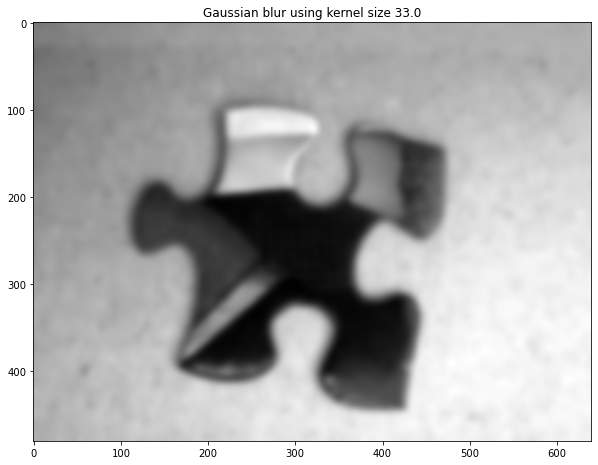

------------------------------------ Intensity Gradients Result ------------------------------------


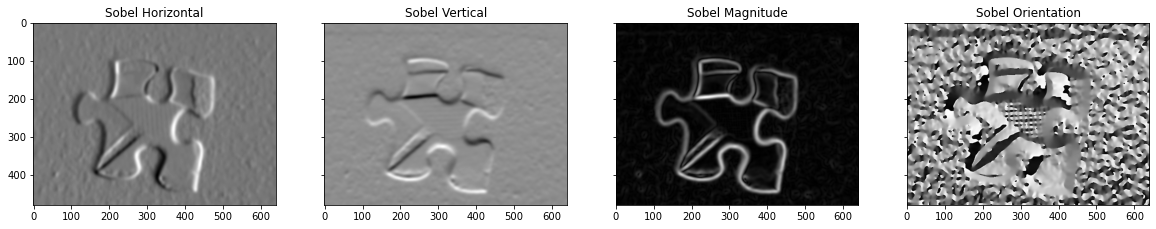

------------------------------------ Non-maximum Suppression Result ------------------------------------


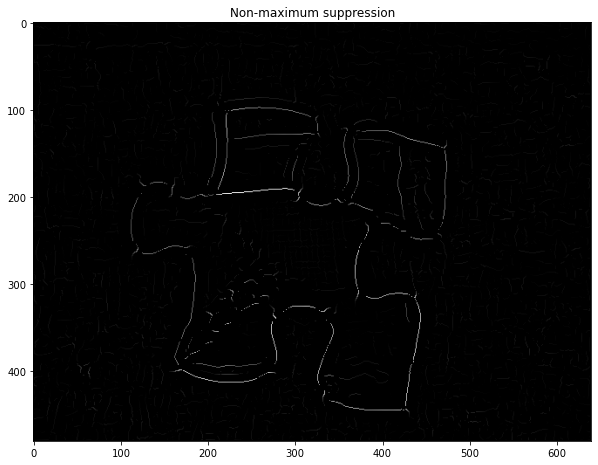

------------------------------------ Double Thresholding Result ------------------------------------


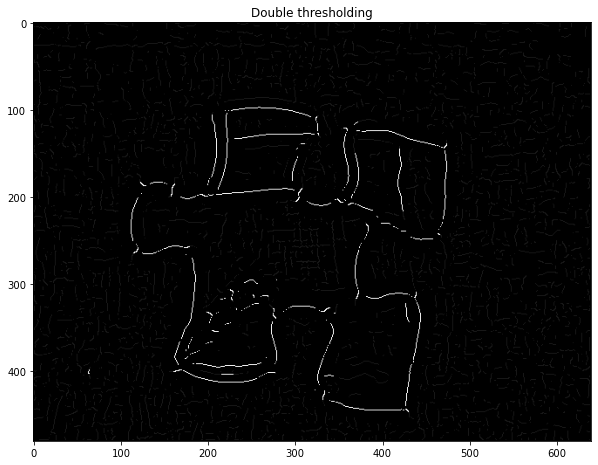

------------------------------------ Hysteresis Result ------------------------------------


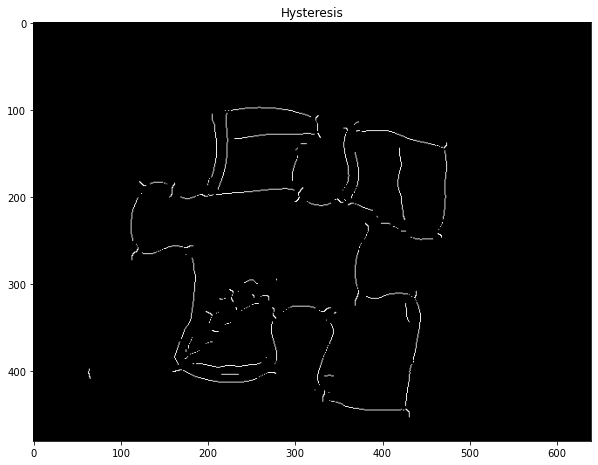

In [9]:
res = Canny_Edge_Detector(img_83_grayscale_rescaled,plot=True)

## 1.3) 
Compare your final result to the skimage canny function (skimage.feature.canny) run with
default arguments.

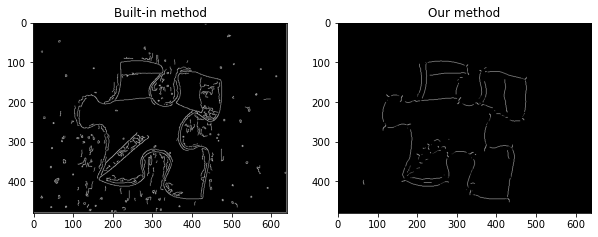

In [10]:
plt.figure(figsize=(10,10))
built_in = feature.canny(img_83_grayscale_rescaled)
plt.subplot(1,2,1),plt.imshow(built_in,cmap="gray"),plt.title("Built-in method")
plt.subplot(1,2,2),plt.imshow(res,cmap="gray"),plt.title("Our method")
plt.show()

## 1.4)
Give reasons for the effect on the output after increasing or decreasing each parameter, including
low threshold, high threshold and σ. Plot your different parameter traversals used to come to
your conclusions. You may use the skimage.feature.canny function for this question.

### Investigating the effect of $\sigma$

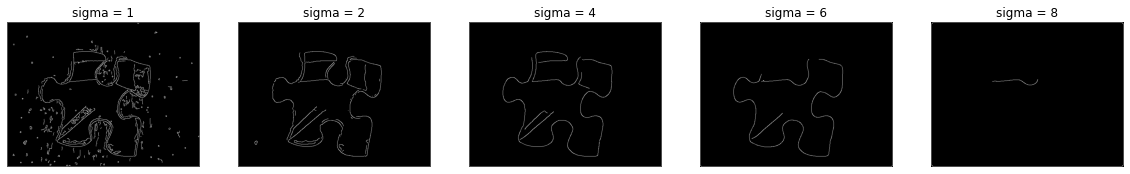

In [11]:
sigma_vals = [1, 2, 4, 6,8]
plt.figure(figsize=(20,20))
index = 1
for sigma in sigma_vals:
  plt.subplot(1, 5, index),plt.imshow(feature.canny(img_83_grayscale_rescaled, sigma, 0.1, 0.2), cmap="gray")

  index += 1
  plt.axis("Off")
  plt.title("sigma = %d" % sigma)


- Lower values of $\sigma$ give us noiser images. The additional noise is then captured as an edge by the algorithm.
- Higher $\sigma$ values reduce the noise, and thus enable the algorithm to capture the correct edges in the image.
- However, as we increaser sigma, fewer and fewer edges are captured since they become blurred by the gaussian kernel.

### Investigating the effect of the high threshold

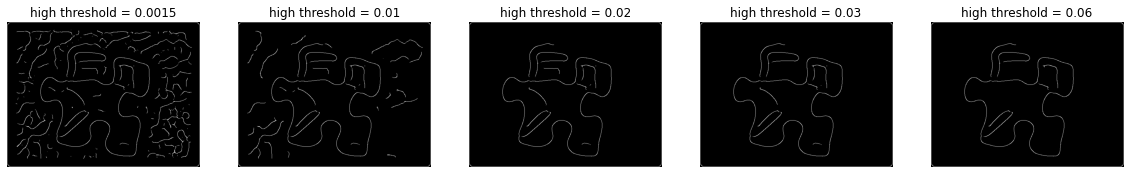

In [12]:
high_threshold_vals = [ 0.0015, 0.01, 0.02, 0.03,0.06]
plt.figure(figsize=(20,20))
index = 1
for t in high_threshold_vals:
  plt.subplot(1, 5, index),plt.imshow(feature.canny(img_83_grayscale_rescaled, 10, 0,t), cmap="gray")

  index += 1
  plt.axis("Off")
  plt.title(f"high threshold = {t}")


- Higher values for the high threshold enables us to preserve fewer edges since the threshold means we need to be more sure of an edge.
- However, there exists a cutoff point where beyond this point, the algorithm may actually remove legitimate edges because the threshold is too high.

### Investigating the effects of the low threshold

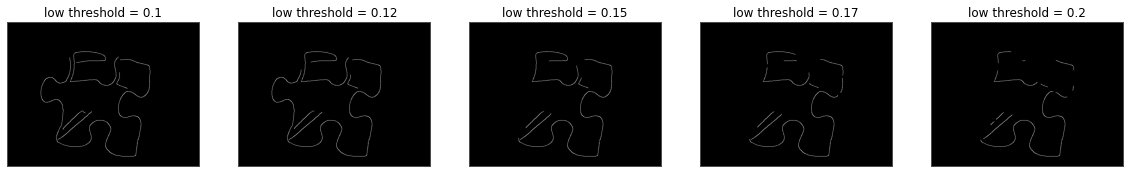

In [13]:
low_threshold_vals = [0.1,0.12,0.15,0.17,0.2]
plt.figure(figsize=(20,20))
index = 1
for t in low_threshold_vals:
  plt.subplot(1, 5, index),plt.imshow(feature.canny(img_83_grayscale_rescaled, 4.0, t,0.2), cmap="gray")

  index += 1
  plt.axis("Off")
  plt.title(f"low threshold = {t}")

 - Increasing low_threshold results in an increase in the confidence our algorithm needs to have about an edge in order to keep it. 
 - As a result, when the low threshold is too low we end up keeping unnecessary edges, and when it is too high we may end up dropping relevant edges.

## 1.5)
Adjust the parameters of your implementation to try and obtain the best or cleanest result. Plot
this result with your chosen parameters. Again you may use the skimage.feature.canny
function.

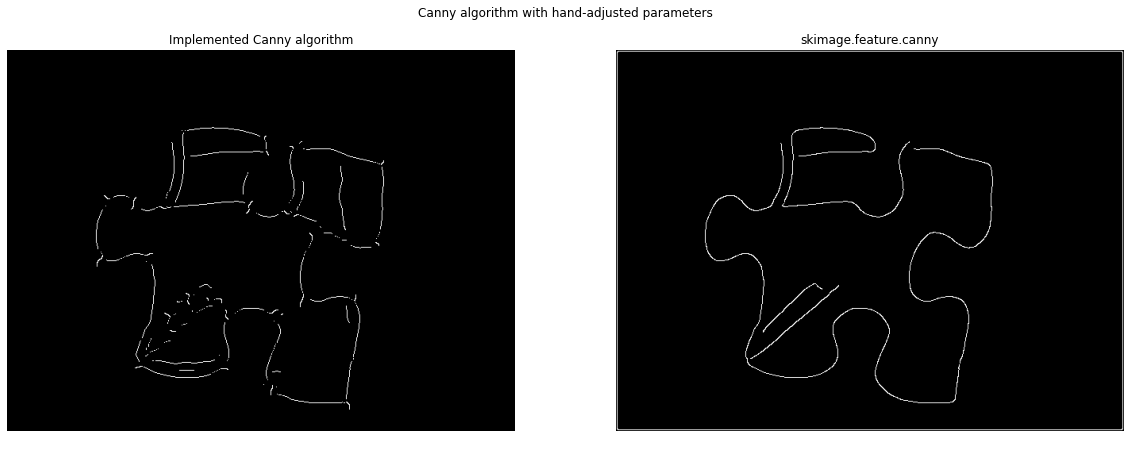

In [14]:
sigma = 4
low_threshold = 0.1
high_threshold = 0.23

canny_best= Canny_Edge_Detector(img_83_grayscale_rescaled, sigma, low_threshold=low_threshold, high_threshold=high_threshold)

fig6 = plt.figure(figsize=(20,8))
plt.axis("Off")
plt.title("Canny algorithm with hand-adjusted parameters")
fig6.add_subplot(1, 2, 1)
plt.axis("Off")
plt.title("Implemented Canny algorithm")
plt.imshow(canny_best, cmap="gray")
fig6.add_subplot(1, 2, 2)
plt.axis("Off")
plt.title("skimage.feature.canny")
plt.imshow(feature.canny(img_83_grayscale_rescaled,sigma,low_threshold,high_threshold), cmap="gray")
plt.show()

# 2) Harris Corner Detector

## 2.1) 
Your task is to implement the Harris Corner Detector, your function signature should accept a
greyscale image with three additional tuneable named parameters (defaults are given below): $\sigma, \kappa, \tau$, where $\sigma$ is the standard deviation of the Gaussian filter representing the weight matrix,
$\kappa$  is the sensitivity factor that separates corners from edges and $\tau$  is the normalised response
threshold.

### Step 1
Compute your vertical and horizontal image derivatives from your greyscale image using
the appropriately oriented Sobel filters and zero padding.

In [15]:
def img_derivatives(img):
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    sobelx = sig.convolve2d(img, kernel_x, mode='same')
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    sobely= sig.convolve2d(img, kernel_y, mode='same')
    return sobelx,sobely

### Step 2
Use these derivatives to compute your image structure tensors ($S_{ij}$ in your textbook),
weighted according to the Gaussian with default $\sigma$ = 1. Again use zero padding.

In [16]:
def create_structure_tensors(sobelx,sobely,sigma):
    truncate= 4
    radius = np.floor((truncate*sigma)+0.5)
    size = int((2*radius) + 1)
    I_xx = cv.GaussianBlur(sobelx**2, (size,size), sigma, borderType=cv.BORDER_CONSTANT)
    I_yy = cv.GaussianBlur(sobely**2, (size, size), sigma, borderType=cv.BORDER_CONSTANT)
    I_xy = cv.GaussianBlur(sobely*sobelx, (size, size), sigma, borderType=cv.BORDER_CONSTANT)

    return I_xx,I_yy,I_xy

### Step 3
Calculate the responses (cij ) from the structure tensors, with the default value for $\kappa$ = 0.05.

In [17]:
def response_structure_tensor(I_xx,I_yy,I_xy,kappa):
    trace = I_xx + I_yy
    determinant = (I_xx * I_yy) - (I_xy**2)
    response = determinant - (kappa*(trace**2))
    return response

### Step 4
Remove spurious corners from the responses by only keeping local maxima, do this by
analysing the 8 neighbouring values of the centre value in a 3x3 sliding window and keeping the centre only if it is greater than or equal to its neighbours.

In [18]:
def remove_spurious_corners(img):
  result = img.copy()
  rows,cols = np.shape(img)

  img_padded = cv.copyMakeBorder(img, 1, 1, 1, 1, borderType=cv.BORDER_CONSTANT, value=0)
  for i in range(1, rows - 1):
    for j in range(1, cols - 1):
      neighbours = img_padded[i-1:i+2,j-1:j+2]
      maximum = np.amax(neighbours)

      if img_padded[i][j] > maximum:
        result[i][j] = img_padded[i][j]
      else:
        result[i][j] = maximum

  return result

### Step 5
Use the default threshold ratio $\tau$ = 0.05 to return the points where $\frac{responses}{max(responses)} > \tau$.

In [19]:
def getPoints(img,tau):

    tmp = img.copy()
    max2 = np.amax(tmp)
    tmp = tmp/max2

    points = np.where(tmp > tau)

    return points

### Putting all the steps together

In [20]:
def Harris_Corner_Detector(img , sigma = 1, kappa = 0.05, tau = 0.05):
    sobelx,sobely = img_derivatives(img)
    Ix,Iy,Ixy = create_structure_tensors(sobelx,sobely,sigma)
    response = response_structure_tensor(Ix,Iy,Ixy,kappa)
    no_spurious_corners = remove_spurious_corners(response)
    corners = getPoints(no_spurious_corners,tau)
    return sobelx,sobely,Ix,Iy,Ixy,response,no_spurious_corners,corners

## 2.2) 
Apply your Harris corner detector to the mask image with default arguments and plot the de-
tected corners by drawing circles around them.

In [21]:
def draw_circles(img,points):
  result = img.copy()
  n = len(points[0])
  for i in range (n):
    cv.circle(result, (points[1][i],points[0][i]), radius=12, color=(0,255,0), thickness=2)
  return result

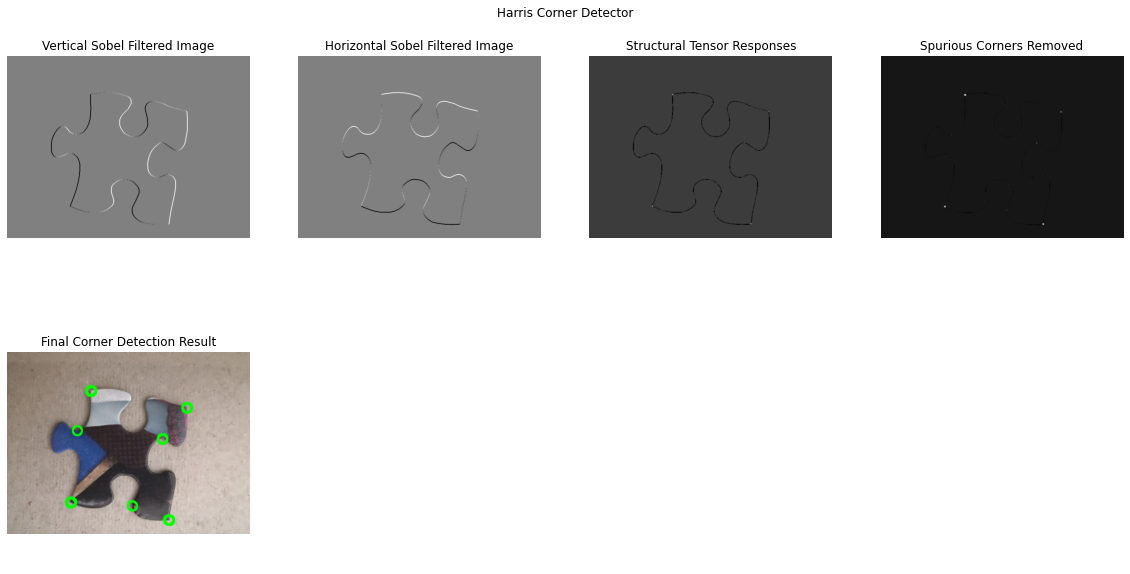

In [22]:
sobelx,sobely,Ix,Iy,Ixy,response,no_spurious_corners,corners = Harris_Corner_Detector(img_83_mask_rescaled)

fig = plt.figure(figsize=(20, 10))
plt.axis("Off")
plt.title("Harris Corner Detector")

fig.add_subplot(2, 4, 1)
plt.axis("Off")
plt.title("Vertical Sobel Filtered Image")
plt.imshow(sobelx, cmap="gray")

fig.add_subplot(2, 4, 2)
plt.axis("Off")
plt.title("Horizontal Sobel Filtered Image")
plt.imshow(sobely, cmap="gray")

fig.add_subplot(2, 4, 3)
plt.axis("Off")
plt.title("Structural Tensor Responses")
plt.imshow(response, cmap="gray")

fig.add_subplot(2, 4, 4)
plt.axis("Off")
plt.title("Spurious Corners Removed")
plt.imshow(no_spurious_corners, cmap="gray")

fig.add_subplot(2, 4, 5)
plt.axis("Off")
plt.title("Final Corner Detection Result")
plt.imshow(draw_circles(img_83_rescaled, corners))

plt.show()

### 2.3 
Test different values of $\kappa \in {0.025, 0.05, 0.1, 0.2}$, $ \sigma \in {1, 2, 4, 8}$  and $ \tau \in {0.01, 0.05, 0.1, 0.2}$
with your implementation of the Harris corner detector. You do not need to run through all
permutations of parameters, rather plot a traversal for each parameter and keep the remainder
as the defaults (one plot for each parameter, with a labelled image corresponding to each pa-
rameter value in the set). Perform these tests on the greyscale version of the original image, not
your mask. Draw the points on your images as in the previous question.

### Investigating the effects of $\sigma$

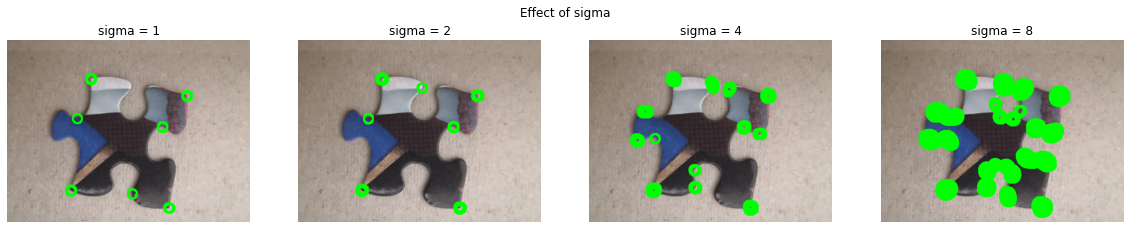

In [23]:
sigmas = [1, 2, 4, 8]
fig = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of sigma")
index = 1
for sigma in sigmas:
  pobelx,sobely,Ix,Iy,Ixy,response,no_spurious_corners,corners = Harris_Corner_Detector(img_83_mask_rescaled, sigma=sigma)

  fig.add_subplot(1, 4, index)
  index += 1
  plt.axis("Off")
  plt.title(f"sigma = {int(sigma)}" )
  plt.imshow(draw_circles(img_83_rescaled, corners))

- Increasing $\sigma$ leads to an increase in the total number of corners identified.
- The increase in $\sigma$  also leads to the points classified as corners to be more closely clustered. Hence we have the thick circles.

### Investigating the effects of $\kappa$

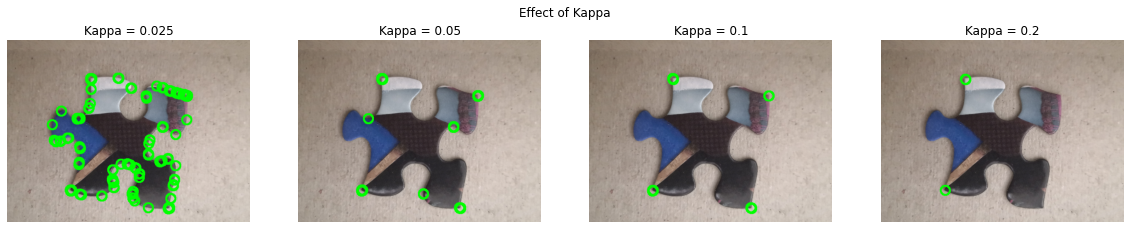

In [24]:
kappas = [0.025,0.05,0.1,0.2]
fig = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of Kappa")
index = 1
for kappa in kappas:
  pobelx,sobely,Ix,Iy,Ixy,response,no_spurious_corners,corners = Harris_Corner_Detector(img_83_mask_rescaled, kappa=kappa)

  fig.add_subplot(1, 4, index)
  index += 1
  plt.axis("Off")
  plt.title(f"Kappa = {kappa}" )
  plt.imshow(draw_circles(img_83_rescaled, corners))

- As we increase $\kappa$, the number of corners detected decreases.
- We need to be wary of having too large a $\kappa$ value, since this will lead to the removal of corners of the image which are important features.

### Investigating the effect of $\tau$

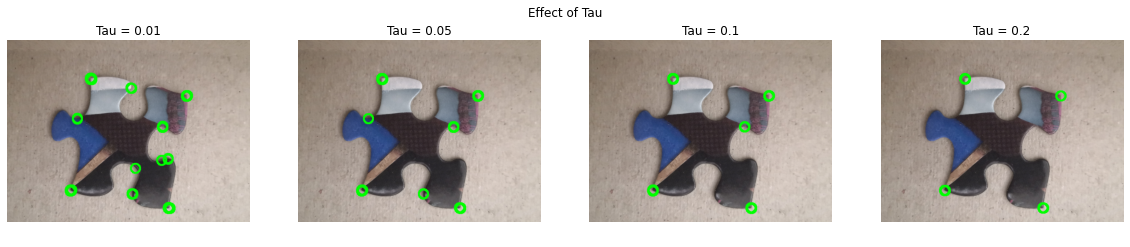

In [25]:
taus = [0.01,0.05,0.1,0.2]
fig = plt.figure(figsize=(20,4))
plt.axis("Off")
plt.title("Effect of Tau")
index = 1
for tau in taus:
  pobelx,sobely,Ix,Iy,Ixy,response,no_spurious_corners,corners = Harris_Corner_Detector(img_83_mask_rescaled, tau=tau)

  fig.add_subplot(1, 4, index)
  index += 1
  plt.axis("Off")
  plt.title(f"Tau = {tau}" )
  plt.imshow(draw_circles(img_83_rescaled, corners))

- Increasing $\tau$ leads to a decrease in the total number of corners identified.
- The increase in $\tau$  also leads to the points classified as corners to be further clustered. Hence we have fewer and more isolated circles.

## 2.4 
How could you further reduce the number of points that are closely clustered together?

- We could use K-means to cluster points and let the centroids of the cluster be the corners.
- In doing so, only points closer to a corner will be clustered with the corner reducing the number of incorrect points clustered at a corner.

# 3) Histogram of Oriented Gradients Descriptor

## 3.1)
Your final task is to implement the Histogram of Oriented Gradients Descriptor (HoG). Create a function that accepts an RGB image and three named arguments orientations = 9,
pixels per cell = 8 and cells per block = 2, the cell size is the number of pixels along one
axis of a square cell, and the block size is the number of cells along one axis of a square block.

In [26]:
def orientation_gradient(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=1)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1, ksize=1)

    mag, angle = cv.cartToPolar(gx, gy, angleInDegrees=True)
    sort_indices = np.argsort(mag,axis=2)
    final_magnitude = np.take_along_axis(mag,sort_indices,axis=2)[:,:,2]
    final_orientation = np.take_along_axis(angle,sort_indices,axis=2)[:,:,2]
    return final_magnitude,final_orientation


In [27]:
def split_into_cells(tmp,pixels_per_cell):
    h,w = tmp.shape
    tmp_split = (tmp.reshape(h//pixels_per_cell, pixels_per_cell, -1, pixels_per_cell)
               .swapaxes(1,2)
               .reshape(-1, pixels_per_cell, pixels_per_cell))
    return tmp_split


def assign_mag_to_bin(magnitudes,orientations,bin_width,n_orientations):
    r,c = orientations.shape
    hist = [0]*n_orientations
    for i in range(r):
        for j in range(c):
            orientation = orientations[i,j]
            magnitude = magnitudes[i,j]
            ## Calculating the main bin
            bin_no = int(orientation//bin_width)
            bin_no_plus_1 = bin_no + 1
            if(bin_no*bin_width == 180 ):
                bin_no = 0
                bin_no_plus_1 = 0
            elif(bin_no == (n_orientations-1)):
                bin_no_plus_1 = 0
                
            percentage_bin_no_plus_one = (orientation/bin_width) - bin_no
            percentage_bin_no = 1 - percentage_bin_no_plus_one

            hist[bin_no] += percentage_bin_no*magnitude
            hist[bin_no_plus_1] += percentage_bin_no_plus_one*magnitude

    return hist

def normalize_vector(v, eps=1e-5):
    v = np.array(v)
    return v / np.sqrt(np.sum(v ** 2) + eps ** 2)


def create_histogram_of_oriented_gradients(magnitude,orientation,n_orientations,pixels_per_cell,cells_per_block):
    bin_width = int(180 / n_orientations)
    r,c = magnitude.shape
    mag_split = split_into_cells(magnitude,pixels_per_cell)
    orientation_split = split_into_cells(orientation,pixels_per_cell)
    hists = []
    n = len(mag_split)
    for i in range(n):
        tmp = assign_mag_to_bin(mag_split[i],orientation_split[i],bin_width,n_orientations)
        hists.append(tmp)

    max_of_histograms = [np.max(a) for a in hists]
    max_of_histograms = np.reshape(max_of_histograms,(r//pixels_per_cell,c//pixels_per_cell))
    rows =  c//pixels_per_cell
    cols =  r//pixels_per_cell
    hists = np.reshape(np.array(hists),(rows,cols,np.shape(hists)[1]))
    normalized_hists=[]
    max_normalized = []
    for i in range(rows-1):
        r1 = hists[i]
        r2 = hists[i+1]

        for j in range(cols-1):
            tmp = []
            tmp.extend(hists[i,j])
            tmp.extend(hists[i,j+1])
            tmp.extend(hists[i+1,j])
            tmp.extend(hists[i+1,j+1])
            normalized = normalize_vector(tmp)
            normalized_hists.append(normalized)
            max_normalized.append(np.max(normalized))

    max_normalized = np.reshape(max_normalized,(cols-1,rows-1))

    return max_of_histograms,normalized_hists,max_normalized

In [28]:
def HOG_Descriptor(img,orientations = 9, pixels_per_cell = 8, cells_per_block = 2):
    w,h,c = img.shape
    assert(w%pixels_per_cell == 0 ),"Width is not a multiple of pixels_per_cell"
    assert(h%pixels_per_cell == 0 ), "Height is not a multiple of pixels_per_cell"
    temp = cells_per_block*pixels_per_cell
    assert(w >= temp), "Width is not large enough"
    assert(h >= temp), "Height is not large enough"

    magnitude,orientation = orientation_gradient(img)
    orientations_unsigned = orientation%180
    max_hists, features,feature_maxes = create_histogram_of_oriented_gradients(magnitude,orientations_unsigned,orientations,pixels_per_cell,cells_per_block)

    return magnitude,orientation,max_hists,feature_maxes,features

## 3.2)
Plot the following steps of your HoG function called with default values as in figure 3, including
the maximal gradient magnitude and orientation images (these images should be the original
image in size), the image formed by taking the max value of each cell’s histogram, and lastly the
image formed by taking the max value of each block’s normalised descriptor vector. Make sure
to label and give the width and height of each image.


In [29]:
magnitude,orientation,max_hists,feature_maxes,features = HOG_Descriptor(img_83_hog)

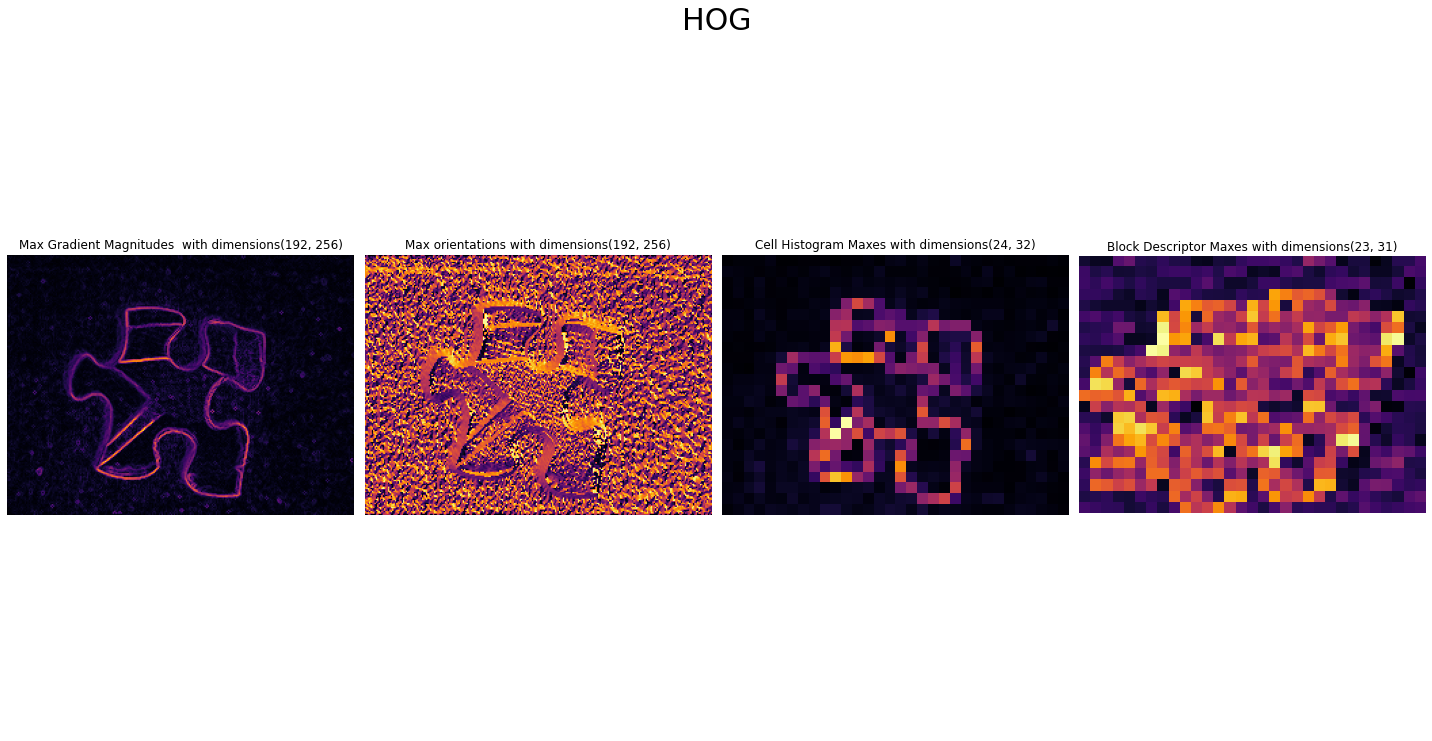

In [30]:
fig = plt.figure(figsize=(20, 10))
plt.axis("Off")
plt.title("HOG",fontsize = 30)

fig.add_subplot(1, 4, 1)
plt.axis("Off")
plt.title(f"Max Gradient Magnitudes  with dimensions{np.shape(magnitude)}")
plt.imshow(exposure.rescale_intensity(magnitude), cmap="inferno")

fig.add_subplot(1, 4, 2)
plt.axis("Off")
plt.title(f"Max orientations with dimensions{np.shape(orientation)}")
plt.imshow(exposure.rescale_intensity(orientation), cmap="inferno")

fig.add_subplot(1, 4, 3)
plt.axis("Off")
plt.title(f"Cell Histogram Maxes with dimensions{np.shape(max_hists)}")
plt.imshow(exposure.rescale_intensity(max_hists), cmap="inferno")


fig.add_subplot(1, 4, 4)
plt.axis("Off")
plt.title(f"Block Descriptor Maxes with dimensions{np.shape(feature_maxes)}")
plt.imshow(exposure.rescale_intensity(feature_maxes), cmap="inferno")
plt.tight_layout()
plt.show()

## 3.3)
For the previous question, what is the shape/size of your final image descriptor?

In [31]:
print(f"The size of the descriptor is: {np.prod(np.shape(features))}")

The size of the descriptor is: 25668


## 3.4)
Outline a method for using the HoG descriptor to detect puzzle pieces in images. Think about
what training samples you would need, the shape and size of the images, how you would break
up larger images, and how you would detect puzzle pieces at different scales.


The steps would be as follows:
1. Pre-processing. This includes resizing the image if necessary as well as normalising the image in order to improve the performance of the algorithm.
2. We would then calculate the gradients
3. Calculate the histogram of gradients
4. Perform block normalisation
5. Get the HOG vectors
6. Pass the descriptor vectors into a classification model

- We would have to pass almost all the puzzle images into the classifier to gain a could understanding of what the puzzle pieces are. This is computationally expensive and is even more computationally expensive since the classifier will perform poorly on puzzles that have been rotated or the size has been altered, since HoG is rotationally and scale invariant.
- In general however, we do not expect the size of a puzzle piece belonging to a single set to vaty greatly. We also know that the HoG cannot be utilised on different size images, so for better results we will have to keep the shape and size of image in the dataset uniform to avoid the scale invariance downfall.
- For larger images, we can alter the hyperparameters to ensure that local information is adequately captured. These include the cell size etc which dictate the formation of the histograms.
- In order to use the HoG to detect puzzles at different sizes, if the puzzle is small and shrunken, i would decrease the size of the image until the puzzle piece becomes a relatively large object in the image. This will ensure that the HOG identifies the puzzle as an object.


## 3.5)
Is the HoG descriptor a good method for detecting puzzle pieces in the previous question, give
reasons for why or why not - If not, can you suggest an alternative?

- One of the shortfalls of the HOG is the fact that it is not rotationally invariant.
- Consequently in order to use the HOG to detect puzzle pieces would be extremely difficult, since a puzzle piece can be rotated in multiple directions.
- Thus, to combat this we would require multiple images of a puzzle piece, where each subsequent picture contains and altered rotation. This is impractical and will even be computationally inefficient.

- Even though the algorithm was designed for Human detection on images with size 64x128, the algorithm still performs well on images of larger sizes. However, the hyperparameters of the algorithm will have to be tweaked and altered in order to find the best features for the dataset.
- In order to detect puzzles at different scales, we can alter the size of the cell we use to create the histograms. This will enable us to either deal with larger images if we increase the size or smaller images if we decrease the size. However, this is computationally expensive and leads to the other issue of HOG which is scale invariance.
- Therefore, the HOG can be used for puzzle piece detection but the SIFT detector which is rotationally and scale invariant might prove better.

# Discussion
At the end of the notebook briefly comment on the algorithms and discuss your results. How might these algorithms contribute to Tino’s puzzle-solving system? What problems do you still envisage we will need to solve before we can complete the system?


### Canny Edge Detector
- We can utilise the canny edge detector in order to identify the edge of the puzzle pieces. We can then classify all pixels on the outside of the edges as background and pixels within the edges as foreground.
- Having the foreground segmented enables us to work with solely the shape of the puzzle piece without background interference.

### Harris Corner Detector
- We can utilise the Harris corner detector to find the corners of the puzzle piece. These are especially important since the corners can tell us which pieces can be joined in order to complete the puzzle.
- By having the corners we can utilise some sort of search algorithm with the edges of all the other pieces to find the piece which matches.

### HoG
- We can use the HoG to actually detect where the puzzle pieces are within an image. 
- The scale and rotational invariance makes it difficult to use it to build the puzzle. However, if we are not concerned about the computational expense, we can utilise the HoG.

### What problems do you still envisage we will need to solve before we can complete the system?
- The canny edge detector gives us the edges of the puzzle, however at times there are gaps between the edges. The gaps can pose an issue. To overcome this, we can find the contours of the puzzle pieces which will give us a solid line for the edge of the puzzle.
- Even though the corners are important, we cannot solve the puzzle with solely the corners. If we utilise shape models, in conjunction with the corners, we will have a better chance of solving the puzzles correctly since we can exploit common information from pieces which will be joined together.